# YOU NEEED: 
    - 200 GB to run
    - Lots of DASK
    
# TO DO: 
- Bootstrap ERROR (Spatial + Lat)
    
# To Run: 
 
 - visit SPECIFY cell 
 - Run All

# Experiments: 
    -Free Running: 
        -/glade/campaign/cisl/aiml/wchapman/CAM_runs/f.e21.DAcompset.f09_d025_free_MJO_1982
        - path_tofiles=/glade/campaign/cisl/aiml/wchapman/CAM_runs/' + modvers + '/atm/hist/*h1*.nc
    -Nudge No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982
    -Nudge Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3
        - path_tofiles='/glade/scratch/wchapman/archive/' + modvers + '/atm/hist/*h1*.nc'
    -DA No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982
    -DA Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_05_1982/
    -obs
        -/glade/scratch/wchapman/TEMPERAI/

## SPECIFY
- this requires and ADF directory with Z500 in it... or it will make one... 

In [25]:
modvers = 'f.e21.DAcompset.f09_d025_free_MJO_1982'
fil_out = '/glade/scratch/wchapman/ADF/' + modvers +'/ts/' + modvers + '.h1.Z500.198201-201012.nc'
fil_out_blocked = '/glade/scratch/wchapman/ADF/' + modvers +'/ts/' + modvers + '.h1.BLOCKED.198201-201012.nc'
path_tofiles='/glade/scratch/wchapman/archive/' + modvers + '/atm/hist/*h1*.nc'
remake_files = False
from_SF = False

## comparison model for the good one ... 
modvers_comp = 'f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3'
fil_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.Z500.198201-201012.nc'
fil_out_blocked_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.BLOCKED_SF.198201-201012.nc'
path_tofiles_comp ='/glade/scratch/wchapman/archive/' + modvers_comp + '/atm/hist/*h1*.nc'
remake_files_comp = False
from_SF = False


## SF 
modvers_comp = 'f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3'
fil_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.UV500.198201-201012.nc'
fil_out_blocked_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1_SF.BLOCKED_SF.198201-201012.nc'
path_tofiles_comp ='/glade/scratch/wchapman/archive/' + modvers_comp + '/atm/hist/*h1*.nc'
remake_files_comp = False
from_SF = True 

## Functions

In [68]:
def is_doyrange(doy,dd,tod,hh):
    daywind = 45
    if (dd - daywind) < 1:
        return ((doy >= (366+(dd-daywind))) | (doy <= dd+daywind)) & (tod==hh)
        
    elif (dd + daywind) > 366:
        
        return ((((doy <= 366) & (doy>=(dd-daywind))) | (doy <= (366-(dd-daywind)))))&(tod==hh)
    
    else:
        return ((doy >= dd-daywind) & (doy <= dd+daywind))&(tod==hh)
    

## Z500 from the Streamfunction

In [65]:
Z500 = xr.open_dataset('/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.Z500.ERAgrid.198201-201012.nc')
Z500.load()

UV500 = xr.open_dataset('/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.UV500.ERAgrid.198201-201012.nc')
UV500.load()

<xarray.Dataset>
Dimensions:  (time: 10593, lat: 73, lon: 144)
Coordinates:
    lev      float64 524.7
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2011-01-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    V        (time, lat, lon) float32 2.868 2.868 2.868 ... -6.25 -6.25 -6.25
    U        (time, lat, lon) float32 4.193 4.193 4.193 ... 5.273 5.273 5.273
Attributes:
    regrid_method:  bilinear

In [71]:
%%time

uwnd=UV500['U'].load()
vwnd=UV500['V'].load()
w = VectorWind(uwnd, vwnd)
psi = w.streamfunction().to_dataset(name='streamfunction')
pvrt = w.planetaryvorticity()


Z500_climo = xr.zeros_like(Z500['Z500'])
print('... creating climo from centered 30 day average ...')
for ee,dayhr in (enumerate(pd.date_range(start=Z500['time'][0].values,end=Z500['time'][-1].values)[:-1])):
    if ee%50 ==0:
        print('doing ',ee,' of 365')
    dooDOY = dayhr.dayofyear
    hh=dayhr.hour
    Dtemp = Z500.sel(time=is_doyrange(Z500['time.dayofyear'],dooDOY,Z500['time.hour'],hh))[['Z500']].mean(['time'])
    Z500_climo[ee,:,:] = Dtemp['Z500'].values
    
    if ee == (365)+11:
        endee=ee
        enddate = dayhr
        break
        
print('...now repeating climo...') 
for ee,dayhr in (enumerate(pd.date_range(start=enddate,end=Z500['time'][-1].values)[:-1])):
    getday = str(Z500['time.year'][0].values)+'-'+f'{dayhr.month:02}'+'-'+f'{dayhr.day:02}'
    
    #leap year shenanigans:
    if f'{dayhr.month:02}'+'-'+f'{dayhr.day:02}' == '02-29': 
        getday = str(Z500['time.year'][0].values)+'-02-28'
        
    if ee%1000 ==0:
        print('doing ',ee,' of ', len(Z500['time']))
        
    DtempZ500 = Z500_climo.sel(time=getday)
       
    Z500_climo[ee+endee+1,:,:] = DtempZ500.values

... creating climo from centered 30 day average ...
doing  0  of 365
doing  50  of 365
doing  100  of 365
doing  150  of 365
doing  200  of 365
doing  250  of 365
doing  300  of 365
doing  350  of 365
...now repeating climo...
doing  0  of  10593
doing  1000  of  10593
doing  2000  of  10593
doing  3000  of  10593
doing  4000  of  10593
doing  5000  of  10593
doing  6000  of  10593
doing  7000  of  10593
doing  8000  of  10593
doing  9000  of  10593
doing  10000  of  10593
CPU times: user 1min 13s, sys: 20.2 s, total: 1min 33s
Wall time: 1min 28s


## Build or Load OBS

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import scipy
import copy
import math
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker

#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker


# import scipy
from datetime import datetime
import os
# import utils
import importlib


# import statsmodels.api as sm
# from windspharm.xarray import VectorWind
# from windspharm.standard import VectorWind
# from windspharm.examples import example_data_path
# from windspharm.tools import prep_data, recover_data, order_latdim
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from shapely.geometry.polygon import LinearRing
from dask.diagnostics import ProgressBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import math
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import geocat.comp as gcomp
import shutil
import metpy.calc as mpcalc
import numba as nb
from numba import njit, prange


In [32]:
from windspharm.xarray import VectorWind
# from windspharm.standard import VectorWind
from windspharm.examples import example_data_path
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.tools import prep_data, recover_data
import spharm.spharm

## Get ADF to do this for you

In [1]:
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

In [2]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(project='P54048000',walltime='06:00:00')
cluster.scale(40)
client = Client(cluster)
client

## Free Running:

### helpful functions

In [6]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def is_DJF(month):
    return (month == 12) | (month == 1) | (month == 2)

def is_J(month):
    return (month == 1)
    
def is_D(month):
    return (month == 12)
    
def is_F(month):
    return (month == 2)


def wgt_rmse(fld1, fld2, wgt):
    """Calculated the area-weighted RMSE.
    Inputs are 2-d spatial fields, fld1 and fld2 with the same shape.
    They can be xarray DataArray or numpy arrays.
    Input wgt is the weight vector, expected to be 1-d, matching length of one dimension of the data.
    Returns a single float value.
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.nansum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()

#######

def calculate_blocked_data(path_tofiles, fil_out, fil_out_blocked, remake_files=False,from_SF = False):
    """
    Calculate blocked data for given files.

    Parameters:
    path_tofiles (str): Path to the files.
    fil_out (str): Path to the output file for chunked data.
    fil_out_blocked (str): Path to the output file for blocked data.
    remake_files (bool, optional): Whether to remake the output files if they exist. Defaults to False.

    Returns:
    blocked_data (xarray.Dataset): The blocked data.
    bbedo_chunked (xarray.Dataset): The chunked data.
    """
    
    
    
    # List of variables to use
    dovars = ['Z500']
    
    # Remove output file if it exists and remake_files is True
    if (os.path.exists(fil_out)) and (remake_files):
        os.remove(fil_out)
    
    # If output file does not exist, create chunked data and save it
    if not os.path.exists(fil_out):
        fns = sorted(glob.glob(path_tofiles))
        program_starts = time.time()
        for ee, group in enumerate(chunker(fns, 100)):
            print(f'doing group: {ee} of {len(fns) / 100}')
            DS = xr.open_mfdataset(group, parallel=True)
            print('..opened..')
            if ee == 0:
                # bbedo = DS[dovars].load()
                bbedo = DS[dovars]
            else: 
                # temp_bbedo = DS[dovars].load()
                temp_bbedo = DS[dovars]
                print('concat')
                bbedo = xr.concat([bbedo,temp_bbedo], dim='time')
            now = time.time()
            print(f"It has been {now - program_starts} seconds since the loop started")
        bbedo_chunked = bbedo.chunk({'time': 100, 'lat': 192, 'lon': 288})
        bbedo_chunked.to_netcdf(fil_out)
    else:
        print('file existed... opening')
        bbedo = xr.open_dataset(fil_out)
        
    if from_SF==True:
        dog=3

    bbedo_chunked = bbedo.chunk({'time': 100, 'lat': 192, 'lon': 288})

    print('.... done done done....')
    bbedo_chunked.load()
    print('.... loaded ....')
    
    # Define the function that does the blocking check
    @nb.njit(nopython=True)
    def is_blocked(NH_do_chunk, NH_S_chunk, NH_N_chunk):
        if (np.sum((NH_do_chunk - NH_S_chunk) > 0) == 5) and (np.sum((NH_do_chunk - NH_N_chunk) > 150) == 5):
            return 1
        else:
            return 0

    # Remove output file if it exists and remake_files is True
    if (os.path.exists(fil_out_blocked)) and (remake_files):
        os.remove(fil_out_blocked)

    # If output file does not exist, calculate blocked data and save it
    if not os.path.exists(fil_out_blocked):
        print('file does not exist... creating..')
        # Loop over latitudes and longitudes, using Numba to speed up the loop
        lat_loop = bbedo_chunked['lat'].sel(lat=slice(30, 75))
        lon_loop = bbedo_chunked['lon']
        blocked_ = np.zeros([10593,48,288])

        for lala_e, lala in enumerate(lat_loop[:]):
            print(lala.values)
            for lolo_e, lolo in enumerate(lon_loop[:]):
                # print(lolo.values)
                NH_S = bbedo_chunked['Z500'].sel(lat=lala.values - 15, lon=lolo, method='nearest').values
                NH_do = bbedo_chunked['Z500'].sel(lat=lala.values, lon=lolo, method='nearest').values
                NH_N = bbedo_chunked['Z500'].sel(lat=lala.values + 15, lon=lolo, method='nearest').values
                for ii in range(5, len(NH_do)):
                    NH_do_chunk = NH_do[ii - 5:ii]
                    NH_S_chunk = NH_S[ii - 5:ii]
                    NH_N_chunk = NH_N[ii - 5:ii]
                    blocked_[ii, lala_e, lolo_e] = is_blocked(NH_do_chunk, NH_S_chunk, NH_N_chunk)


        BE = np.zeros([10593,192,288])
        BE[:,128:176,:] = blocked_
        # Create a new xarray dataset to store the blocked data
        blocked_data = xr.Dataset(
            data_vars={
                'blocked': (('time', 'lat', 'lon'), BE)
            },
            coords={
                'time': bbedo_chunked['time'],
                'lat': bbedo_chunked['lat'].values,
                'lon': bbedo_chunked['lon'].values
            }
        )

        blocked_data.to_netcdf(fil_out_blocked)
    else:
        print('file existed... opening')
        blocked_data = xr.open_dataset(fil_out_blocked)

    # Return both the blocked data and the chunked data
    return blocked_data, bbedo_chunked




## Load Model Data

In [7]:
blocked_data_comp, bbedo_chunked_comp = calculate_blocked_data(path_tofiles_comp, fil_out_comp, fil_out_blocked_comp, remake_files=False)
print('1')
blocked_data, bbedo_chunked = calculate_blocked_data(path_tofiles, fil_out, fil_out_blocked, remake_files=False)

file existed... opening
.... done done done....
.... loaded ....
file existed... opening
1
file existed... opening
.... done done done....


/glade/u/home/wchapman/.local/lib/python3.9/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


.... loaded ....
file existed... opening


/glade/u/home/wchapman/.local/lib/python3.9/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Build or Load Obs

In [8]:
%%time
fns = sorted(glob.glob('glade/scratch/wchapman/TEMPERAI/ERAi_z500.camgrid_*.nc'))


obs_out = '/glade/scratch/wchapman/ADF/ERAi.h1.Z500.198201-201012.nc'
obs_out_blocked = '/glade/scratch/wchapman/ADF/ERAi.h1.BLOCKED.198201-201012.nc'

dovars = ['z']

if (os.path.exists(obs_out)) & (remake_files):
    os.remove(obs_out)

if not os.path.exists(obs_out):    
    fns = sorted(glob.glob('/glade/scratch/wchapman/TEMPERAI/ERAi_z500.camgrid_*.nc'))
    program_starts = time.time()
    for ee,group in enumerate(chunker(fns,30)):
        print('doing group: ',ee,' of ',len(fns)/30)
        # print(group)
        DS = xr.open_mfdataset(group,parallel=True)
        
        print('..opened..')
        if ee == 0:
            # bbedo = DS[dovars].load()
            bbedo = DS[dovars]
        else: 
            # temp_bbedo = DS[dovars].load()
            temp_bbedo = DS[dovars]
            print('concat')
            bbedo = xr.concat([bbedo,temp_bbedo],dim='time')

        now = time.time()
        print("It has been {0} seconds since the loop started".format(now - program_starts))
        bbedo = bbedo.sel(time=slice('1982-01-01','2011-01-01'))
        print('...resampling...')
        bbedo = bbedo.resample(time="D").mean()
else:
    print('file existed... opening')
    bbedo = xr.open_dataset(obs_out)

bbedo = bbedo.rename({'z':'Z500'})
bbedo_chunked = bbedo.chunk({'time':100, 'lat':192, 'lon':288})
bbedo_chunked.load()
# Define the function that does the blocking check
@nb.njit(nopython=True)
def is_blocked(NH_do_chunk, NH_S_chunk, NH_N_chunk):
    if (np.sum((NH_do_chunk - NH_S_chunk) > 0) == 5) and (np.sum((NH_do_chunk - NH_N_chunk) > 150) == 5):
        return 1
    else:
        return 0

if (os.path.exists(obs_out_blocked)) & (remake_files):
    os.remove(obs_out_blocked)
    
if not os.path.exists(obs_out_blocked):
    print('file does not exist... creating..')
    # Loop over latitudes and longitudes, using Numba to speed up the loop
    lat_loop = bbedo_chunked['lat'].sel(lat=slice(30, 75))
    lon_loop = bbedo_chunked['lon']
    blocked_ = np.zeros([10592,48,288])

    for lala_e, lala in enumerate(lat_loop[:]):
        print(lala.values)
        for lolo_e, lolo in enumerate(lon_loop[:]):
            # print(lolo.values)
            NH_S = bbedo_chunked['Z500'].sel(lat=lala.values - 15, lon=lolo, method='nearest').values
            NH_do = bbedo_chunked['Z500'].sel(lat=lala.values, lon=lolo, method='nearest').values
            NH_N = bbedo_chunked['Z500'].sel(lat=lala.values + 15, lon=lolo, method='nearest').values
            for ii in range(5, len(NH_do)):
                NH_do_chunk = NH_do[ii - 5:ii]
                NH_S_chunk = NH_S[ii - 5:ii]
                NH_N_chunk = NH_N[ii - 5:ii]
                blocked_[ii, lala_e, lolo_e] = is_blocked(NH_do_chunk, NH_S_chunk, NH_N_chunk)

            
    BE = np.zeros([10592,192,288])
    BE[:,128:176,:] = blocked_
    # Create a new xarray dataset to store the blocked data
    blocked_obs_data = xr.Dataset(
        data_vars={
            'blocked': (('time', 'lat', 'lon'), BE)
        },
        coords={
            'time': bbedo_chunked['time'],
            'lat': bbedo_chunked['lat'].values,
            'lon': bbedo_chunked['lon'].values
        }
    )
    blocked_obs_data.to_netcdf(obs_out_blocked)
else:
    print('file existed... opening')
    blocked_obs_data = xr.open_dataset(obs_out_blocked)

file existed... opening
file existed... opening
CPU times: user 848 ms, sys: 2.82 s, total: 3.67 s
Wall time: 4.46 s


/glade/u/home/wchapman/.local/lib/python3.9/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Bootstrap the files... 

In [4]:
%%time
import random
## ##select DJF
blocked_data_comp_DJF = blocked_data_comp.sel(time=is_DJF(blocked_data_comp['time.month'])).sel(time=slice('1982-01-01','2010-12-31'))
blocked_data_DJF = blocked_data.sel(time=is_DJF(blocked_data['time.month'])).sel(time=slice('1982-01-01','2010-12-31'))
blocked_obs_data_DJF = blocked_obs_data.sel(time=is_DJF(blocked_obs_data['time.month']))
# ##select DJF

bsnummy = 500 
opts_ = np.arange(0,len(blocked_data_comp_DJF['time']))
blocked_data_comp_DJF_np = np.array(blocked_data_comp_DJF['blocked'].values)
blocked_data_DJF_np = np.array(blocked_data_DJF['blocked'].values)
blocked_obs_data_DJF_np = np.array(blocked_obs_data_DJF['blocked'].values)


bs_comp  = np.zeros([bsnummy,192,288])
bs_mod  = np.zeros([bsnummy,192,288])
bs_obs = np.zeros([bsnummy,192,288])

# gonna need a numpy version
print('...starting BS...')
for bsbs in range(bsnummy):
    print(bsbs)
    lister_  = np.array(random.choices(list(opts_),k=int(0.9*len(opts_))))
    bs_comp[bsbs,:,:]= np.mean(blocked_data_comp_DJF_np[lister_,:,:],axis=0)
    bs_mod[bsbs,:,:]= np.mean(blocked_data_DJF_np[lister_,:,:],axis=0)
    bs_obs[bsbs,:,:]=np.mean(blocked_obs_data_DJF_np[lister_,:,:],axis=0)
    
bs_blocked_comp = xr.Dataset(
        data_vars={
            'blocked': (('time', 'lat', 'lon'), bs_comp),
            'blocked_95th': (('lat', 'lon'), np.percentile(bs_comp,95,axis=0)),
            'blocked_5th': (('lat', 'lon'), np.percentile(bs_comp,5,axis=0)),
            'blocked_99th': (('lat', 'lon'), np.percentile(bs_comp,99,axis=0)),
            'blocked_1th': (('lat', 'lon'), np.percentile(bs_comp,1,axis=0)),
            'blocked_mean': (('lat', 'lon'), np.mean(bs_comp,axis=0)),
        },
        coords={
            'bs': np.arange(0,500),
            'lat': blocked_data_comp['lat'].values,
            'lon': blocked_data_comp['lon'].values
        }
    )

bs_blocked_mod = xr.Dataset(
        data_vars={
            'blocked': (('time', 'lat', 'lon'), bs_mod),
            'blocked_95th': (('lat', 'lon'), np.percentile(bs_mod,95,axis=0)),
            'blocked_5th': (('lat', 'lon'), np.percentile(bs_mod,5,axis=0)),
            'blocked_99th': (('lat', 'lon'), np.percentile(bs_mod,99,axis=0)),
            'blocked_1th': (('lat', 'lon'), np.percentile(bs_mod,1,axis=0)),
            'blocked_mean': (('lat', 'lon'), np.mean(bs_mod,axis=0)),
        },
        coords={
            'bs': np.arange(0,500),
            'lat': blocked_data['lat'].values,
            'lon': blocked_data['lon'].values
        }
    )


bs_blocked_obs = xr.Dataset(
        data_vars={
            'blocked': (('time', 'lat', 'lon'), bs_obs),
            'blocked_95th': (('lat', 'lon'), np.percentile(bs_obs,95,axis=0)),
            'blocked_5th': (('lat', 'lon'), np.percentile(bs_obs,5,axis=0)),
            'blocked_99th': (('lat', 'lon'), np.percentile(bs_obs,99,axis=0)),
            'blocked_1th': (('lat', 'lon'), np.percentile(bs_obs,1,axis=0)),
            'blocked_mean': (('lat', 'lon'), np.mean(bs_obs,axis=0)),
        },
        coords={
            'bs': np.arange(0,500),
            'lat': blocked_obs_data['lat'].values,
            'lon': blocked_obs_data['lon'].values
        }
    )

In [12]:
def overlap(a,b):
    return a[0] <= b[0] <= a[1] or b[0] <= a[0] <= b[1]

lat = blocked_data_comp['lat']
lon = blocked_data_comp['lon']

bias_comp = np.zeros([len(lat),len(lon)])
bias_mod = np.zeros([len(lat),len(lon)])

blocked_95th_mod= np.array(bs_blocked_mod['blocked_99th'].values)
blocked_5th_mod= np.array(bs_blocked_mod['blocked_1th'].values)
blocked_95th_obs= np.array(bs_blocked_obs['blocked_99th'].values)
blocked_5th_obs= np.array(bs_blocked_obs['blocked_1th'].values)
blocked_95th_comp= np.array(bs_blocked_comp['blocked_99th'].values)
blocked_5th_comp= np.array(bs_blocked_comp['blocked_1th'].values)

cont2 = 0 
for lala in range(len(lat)):
    for lolo in range(len(lon)): 
        mod_5_95 = np.array([ blocked_5th_mod[lala,lolo], blocked_95th_mod[lala,lolo]])
        comp_5_95 = np.array([ blocked_5th_comp[lala,lolo], blocked_95th_comp[lala,lolo]])
        obs_5_95 = np.array([ blocked_5th_obs[lala,lolo], blocked_95th_obs[lala,lolo]])
        
        if (lat[lala]<30) or (lat[lala]>75):
            bias_comp[lala,lolo] = np.nan
            bias_mod[lala,lolo] = np.nan
        else: 
            
            if (obs_5_95[1]<0.01) and (mod_5_95[1]<0.01) and (comp_5_95[1]<0.01):
                bias_comp[lala,lolo] = 1
                bias_mod[lala,lolo] = 1
            else: 
                bias_comp[lala,lolo] = overlap(comp_5_95,obs_5_95)
                bias_mod[lala,lolo] = overlap(mod_5_95,obs_5_95)   

                
da_bias_comp = xr.Dataset(
        data_vars={
            'bias': (('lat', 'lon'), bias_comp),
        },
        coords={
            'lat': blocked_data_comp['lat'].values,
            'lon': blocked_data_comp['lon'].values
        }
    )    

da_bias_mod = xr.Dataset(
        data_vars={
            'bias': (('lat', 'lon'), bias_mod),
        },
        coords={
            'lat': blocked_data['lat'].values,
            'lon': blocked_data['lon'].values
        }
    )        
       
bs_blocked_mod = xr.merge([bs_blocked_mod,da_bias_mod])    
bs_blocked_comp = xr.merge([bs_blocked_comp,da_bias_comp])    

## Plot with Bias

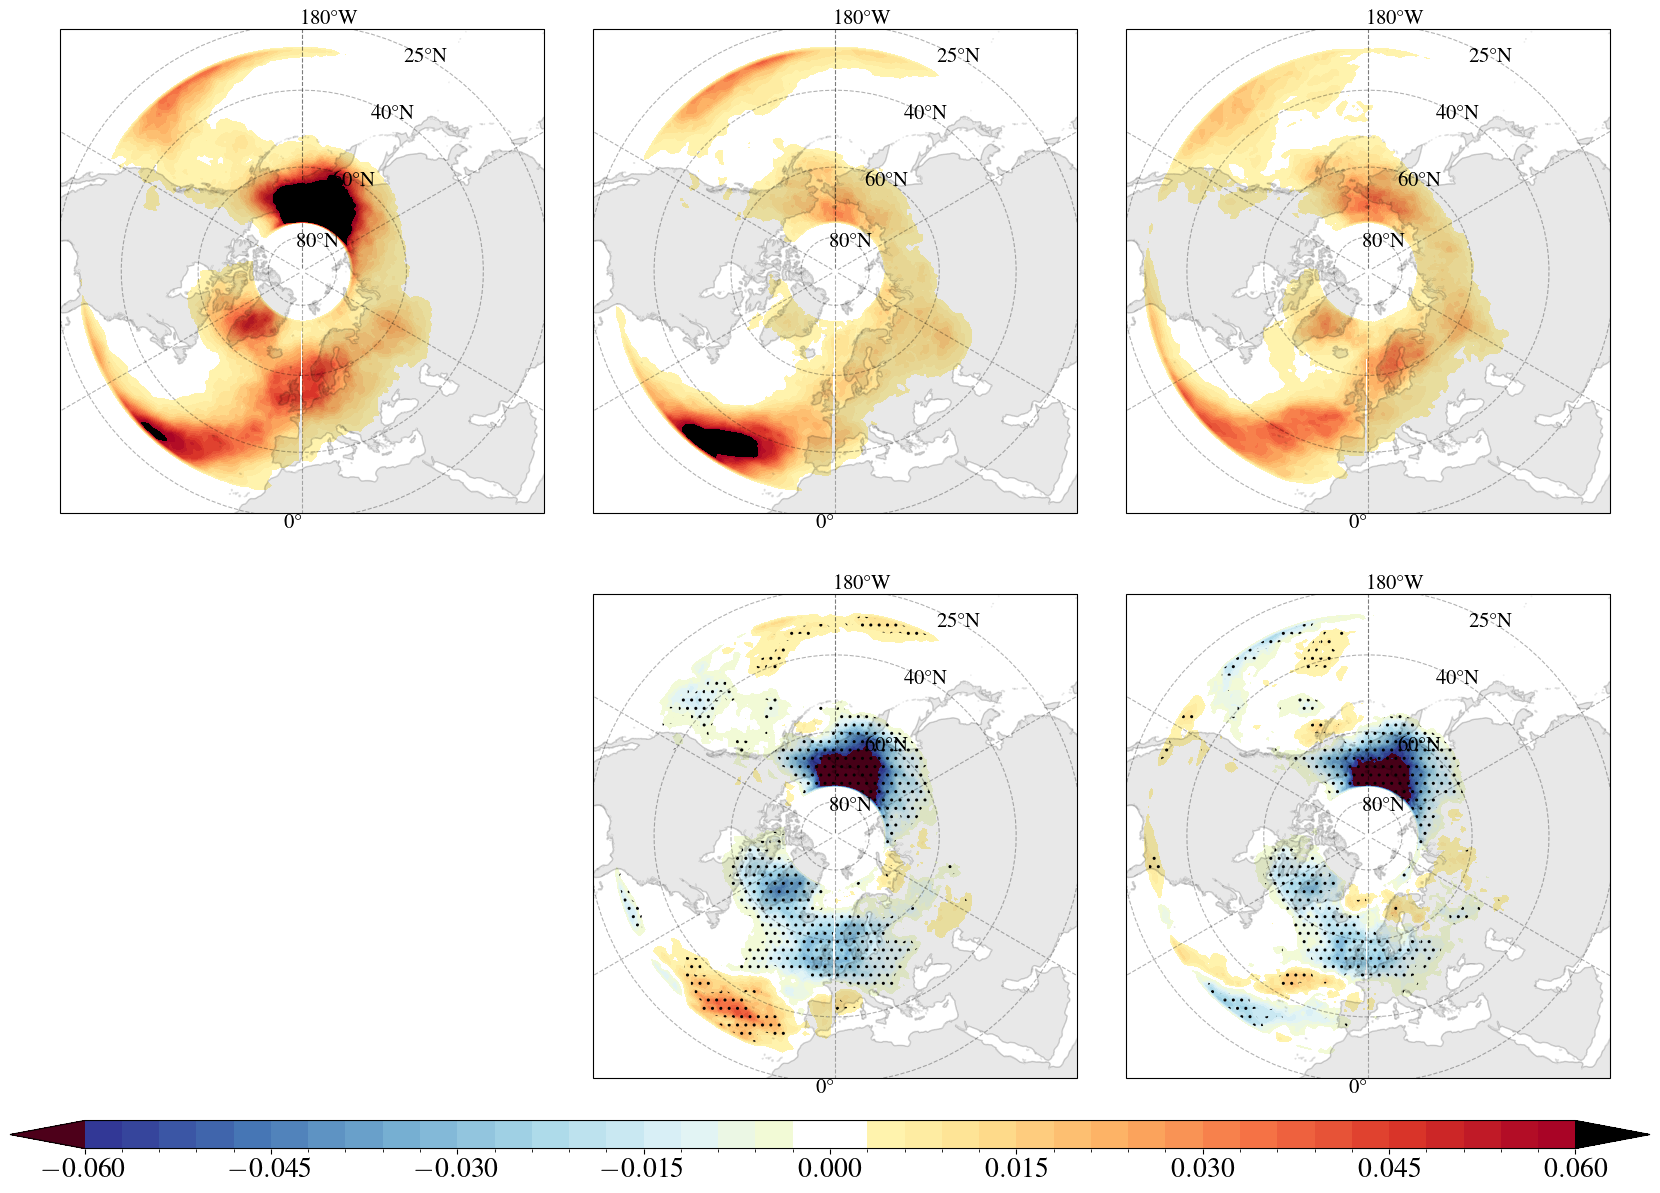

In [14]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

####### +++++ plot 1 +++++ #####################
####### +++++ plot 1 +++++ #####################
####### +++++ plot 1 +++++ #####################
####### +++++ plot 1 +++++ #####################

#### +++ colormap
Max_Pascal=0.06
cmap = plt.colormaps['RdYlBu_r']

cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(1)
# make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)

for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]
cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
cmap.set_under([0.3, 0.00, 0.1, 1.0])
cmap.set_over('k')

levels = MaxNLocator(nbins=40).tick_values(-Max_Pascal,Max_Pascal)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#### --- colormap

#### ++ init fig
fig = plt.figure(figsize=[20,14])
#### -- init fig

### +++ fig left 
ax1 = fig.add_subplot(231, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = blocked_obs_data_DJF['lat']
lon = blocked_obs_data_DJF['lon']
###### +++add cyclic point
plotter = bs_blocked_obs['blocked_mean']
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

cs2=ax1.contourf(np.array(lon),lat,np.array(plotter),levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')
ax1.set_extent([-180, 180, 26, 90], crs=ccrs.PlateCarree())
### --- fig left 

### +++ fig middle 
ax1 = fig.add_subplot(232, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = blocked_obs_data_DJF['lat']
lon = blocked_obs_data_DJF['lon']
###### +++add cyclic point
plotter = bs_blocked_mod['blocked_mean']
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

cs2=ax1.contourf(np.array(lon),lat,np.array(plotter),levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')
ax1.set_extent([-180, 180, 26, 90], crs=ccrs.PlateCarree())
### --- fig middle 


### +++ fig right 
ax1 = fig.add_subplot(233, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = blocked_obs_data_DJF['lat']
lon = blocked_obs_data_DJF['lon']
###### +++add cyclic point
plotter = bs_blocked_comp['blocked_mean']
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

cs2=ax1.contourf(np.array(lon),lat,np.array(plotter),levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')
ax1.set_extent([-180, 180, 26, 90], crs=ccrs.PlateCarree())
### --- fig right 


### +++ fig bottom middle 
ax1 = fig.add_subplot(235, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = blocked_obs_data_DJF['lat']
lon = blocked_obs_data_DJF['lon']
###### +++add cyclic point
plotter = bs_blocked_mod['blocked_mean'] - bs_blocked_obs['blocked_mean']
plotter_bias = bs_blocked_mod['bias']
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

cs2=ax1.contourf(np.array(lon),lat,np.array(plotter),levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')
cs3=ax1.contourf(np.array(lon),lat,np.array(plotter_bias),levels =[-.1,.9], hatches=['..' ,'/'],transform=ccrs.PlateCarree(), cmap='gray',alpha=0)

ax1.set_extent([-180, 180, 26, 90], crs=ccrs.PlateCarree())
### --- fig bottom middle 


### +++ fig bottom right 
ax1 = fig.add_subplot(236, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = blocked_obs_data_DJF['lat']
lon = blocked_obs_data_DJF['lon']
###### +++add cyclic point
plotter = bs_blocked_comp['blocked_mean'] - bs_blocked_obs['blocked_mean']
plotter_bias = bs_blocked_comp['bias']

plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

cs2=ax1.contourf(np.array(lon),lat,np.array(plotter),levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')
cs3=ax1.contourf(np.array(lon),lat,np.array(plotter_bias),levels =[-.1,.9], hatches=['..' ,'/'],transform=ccrs.PlateCarree(), cmap='gray',alpha=0)

ax1.set_extent([-180, 180, 26, 90], crs=ccrs.PlateCarree())
### --- fig bottom right 

## +++inset colorbar:
ax4 = fig.add_axes([0.1, 0.07, 0.82, 0.02])
cb = mpl.colorbar.ColorbarBase(ax4, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=levels, boundaries=levels,orientation='horizontal')
ax4.set_xlabel('%', size=20)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
## ---inset colorbar:
plt.subplots_adjust(wspace=.1,hspace=0.1)
## +++save 

plt.savefig(os.getcwd()+'/Figure_output/'+'BLOCKING_'+modvers_comp+'_500_hpa.png', dpi=200,bbox_inches='tight')

plt.show()
## ---save 

####### ----- plot 1 ---- #####################
####### ----- plot 1 ---- #####################
####### ----- plot 1 ---- #####################
####### ----- plot 1 ---- #####################

In [15]:
weights_cos = np.cos(np.deg2rad(bs_blocked_comp.lat))
weights_cos.name = "weights"
rmse_boots_comp =[]
rmse_boots_mod =[]

for bsbs in range(bsnummy):
    rms_bs = wgt_rmse(bs_blocked_comp.sel(lat=slice(30,65)).isel(time=bsbs)['blocked'],bs_blocked_obs.sel(lat=slice(30,65)).isel(time=bsbs)['blocked'],weights_cos.sel(lat=slice(30,75)))
    rmse_boots_comp.append(rms_bs)
    rms_bs = wgt_rmse(bs_blocked_mod.sel(lat=slice(30,65)).isel(time=bsbs)['blocked'],bs_blocked_obs.sel(lat=slice(30,65)).isel(time=bsbs)['blocked'],weights_cos.sel(lat=slice(30,75)))
    rmse_boots_mod.append(rms_bs)
    
    
    

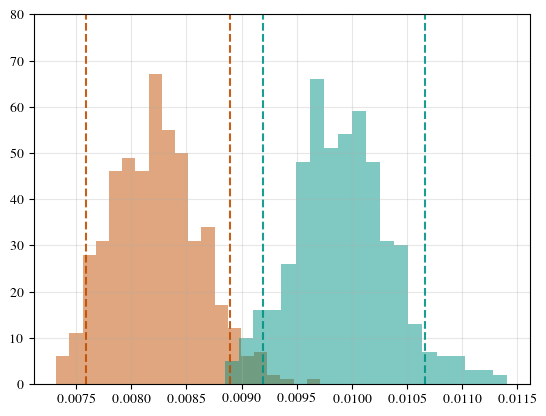

In [16]:
plt.hist(rmse_boots_comp,20,alpha=0.5,color='xkcd:burnt orange',density=False)
perc_5 = np.percentile(rmse_boots_comp,5)
perc_95 = np.percentile(rmse_boots_comp,95)

plt.plot([perc_5,perc_5],[0,90],alpha=0.9,linestyle='--',color='xkcd:burnt orange')
plt.plot([perc_95,perc_95],[0,90],alpha=0.9,linestyle='--',color='xkcd:burnt orange')

plt.hist(rmse_boots_mod,20,alpha=0.5,color='xkcd:teal',density=False)
perc_5 = np.percentile(rmse_boots_mod,5)
perc_95 = np.percentile(rmse_boots_mod,95)

plt.plot([perc_5,perc_5],[0,90],alpha=0.9,linestyle='--',color='xkcd:teal')
plt.plot([perc_95,perc_95],[0,90],alpha=0.9,linestyle='--',color='xkcd:teal')
plt.ylim([0,80])
plt.grid(alpha=0.3)
plt.show()

In [18]:
# bs_blocked_obs['blocked_99th'].values

# fig, ax = plt.subplots(figsize=(12, 4))
# ff2=plt.plot(blockfrq_obs['lon'],blockfrq_obs)

# # plt.contour(lat,plevv,plotterC,levels=contlevels,colors='k',alpha=0.3)
# plt.grid(True)
# plt.ylim([0,0.2])
# #     row.invert_yaxis()
# plt.xlabel('Longitude',fontsize=12)
# plt.ylabel('Frequency',fontsize=12)
# plt.xticks(range(-100,275,25))

# lon_formatter = LongitudeFormatter(number_format='.0f')
# plt.tick_params(labelsize=12) 
# # ax.invert_yaxis()
# ax.xaxis.set_major_formatter(lon_formatter)
# plt.show()

In [3]:
bsnummy = 500
blockfrq_mod = np.zeros([bsnummy,288])
blockfrq_comp = np.zeros([bsnummy,288])
blockfrq_obs = np.zeros([bsnummy,288])

opts_ = np.arange(0,len(blocked_data_comp_DJF['time']))
for bsbs in range(bsnummy):
    print(bsbs)
    lister_  = np.array(random.choices(list(opts_),k=int(0.9*len(opts_))))
    blocked_LON = blocked_data_DJF.isel(time=lister_).sel(lat=slice(0,65)).sum('lat')
    blocked_LON =blocked_LON.where((blocked_LON.blocked < 1), 1) #do things to where condition is true??? 
    blockfrq = blocked_LON.mean('time')['blocked']
    blockfrq_mod[bsbs,:] =  blockfrq.values
    
    
    blocked_LON = blocked_data_comp_DJF.isel(time=lister_).sel(lat=slice(0,65)).sum('lat')
    blocked_LON =blocked_LON.where((blocked_LON.blocked < 1), 1) #do things to where condition is true??? 
    blockfrq = blocked_LON.mean('time')['blocked']
    blockfrq_comp[bsbs,:] =  blockfrq.values
    
    
    blocked_LON = blocked_obs_data_DJF.isel(time=lister_).sel(lat=slice(0,65)).sum('lat')
    blocked_LON =blocked_LON.where((blocked_LON.blocked < 1), 1) #do things to where condition is true??? 
    blockfrq = blocked_LON.mean('time')['blocked']
    blockfrq_obs[bsbs,:] =  blockfrq.values
    
    
bs_blocked_lon = xr.Dataset(
        data_vars={
            'blocked_lon_comp': (('bs', 'lon'), blockfrq_comp),
            'blocked_lon_mod': (('bs', 'lon'), blockfrq_mod),
            'blocked_lon_obs': (('bs', 'lon'), blockfrq_obs),
           
        },
        coords={
            'bs': np.arange(0,bsnummy),
            'lon': blocked_obs_data['lon'].values
        }
    )
    
bs_blocked_lon
bs_blocked_lon.coords['lon'] = (bs_blocked_lon.coords['lon'] + 90) % 360 - 90
bs_blocked_lon = bs_blocked_lon.sortby(bs_blocked_lon.lon)

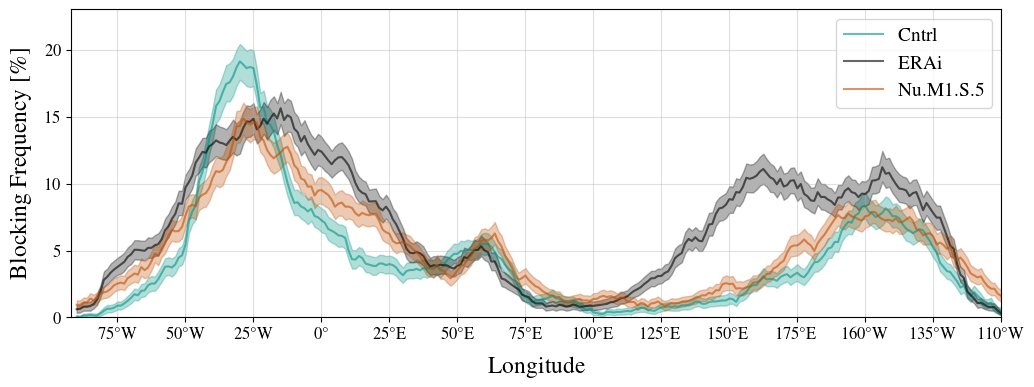

In [91]:
fig, ax = plt.subplots(figsize=(12, 4))

ff=plt.plot(bs_blocked_lon['lon'],bs_blocked_lon['blocked_lon_mod'].mean('bs')*100,color='xkcd:teal',label='Cntrl',alpha=0.6)
ff2=plt.plot(bs_blocked_lon['lon'],bs_blocked_lon['blocked_lon_obs'].mean('bs')*100,color='xkcd:black',label='ERAi',alpha=0.6)
ff2=plt.plot(bs_blocked_lon['lon'],bs_blocked_lon['blocked_lon_comp'].mean('bs')*100,color='xkcd:burnt orange',label='Nu.M1.S.5',alpha=0.6)

# ff=plt.plot(bs_blocked_lon['lon'],bs_blocked_lon['blocked_lon_mod'].T,alpha=0.05,color='red')
# ff2=plt.plot(bs_blocked_lon['lon'],bs_blocked_lon['blocked_lon_obs'].T,alpha=0.05,color='black')
# ff2=plt.plot(bs_blocked_lon['lon'],bs_blocked_lon['blocked_lon_comp'].T,alpha=0.05,color='blue')

plt.fill_between(bs_blocked_lon['lon'],np.percentile(bs_blocked_lon['blocked_lon_mod'],5,axis=0)*100,np.percentile(bs_blocked_lon['blocked_lon_mod'],95,axis=0)*100,alpha=0.3,color='xkcd:teal')
plt.fill_between(bs_blocked_lon['lon'],np.percentile(bs_blocked_lon['blocked_lon_obs'],5,axis=0)*100,np.percentile(bs_blocked_lon['blocked_lon_obs'],95,axis=0)*100,alpha=0.3,color='xkcd:black')
plt.fill_between(bs_blocked_lon['lon'],np.percentile(bs_blocked_lon['blocked_lon_comp'],5,axis=0)*100,np.percentile(bs_blocked_lon['blocked_lon_comp'],95,axis=0)*100,alpha=0.3,color='xkcd:burnt orange')

plt.legend(fontsize=14)
# plt.contour(lat,plevv,plotterC,levels=contlevels,colors='k',alpha=0.3)
plt.grid(True,alpha=0.4)
plt.ylim([0,23])

#     row.invert_yaxis()
plt.xlabel('Longitude',fontsize=17, labelpad=10)
plt.ylabel('Blocking Frequency [\%]',fontsize=17, labelpad=10)
plt.xticks(range(-100,275,25))
plt.xlim([-92,250])

lon_formatter = LongitudeFormatter(number_format='.0f')
plt.tick_params(labelsize=12) 
# ax.invert_yaxis()
ax.xaxis.set_major_formatter(lon_formatter)
plt.savefig(os.getcwd()+'/Figure_output/'+'BLOCKING_latavg_'+modvers_comp+'_500_hpa.png', dpi=200,bbox_inches='tight')

plt.show()